# Scalable computing with `dask`

Up to this point, all computation we've needed to do can be done using a single Python process, without much concern for either speed or memory use. Working on problems outside of this course, however, you may run into cases where:

1. what you need to execute takes an unacceptably long time.
2. the memory required for your task is larger than what your machine has available.

In either of these cases, a tool like `dask` can help us to *scale out* the work we have to do, perhaps over many machines. We'll see how this works in this lesson.

## Performing calculations in serial

We'll start with as simple an example as we can to illustrate one of the core concepts of `dask`: building graphs that describe the computation we want to perform using Python code. We'll define a couple toy functions that we'll use for computing some result:

In [1]:
import time

In [2]:
def inc(x):
    time.sleep(1)
    return x + 1

In [3]:
def add(a, b):
    time.sleep(1)
    return a + b

The first function, `inc`, takes a single input, `x`, and returns `x + 1`. The second function, `add`, takes two inputs, `a` and `b`, and returns `a + b`. Each function includes a call to `time.sleep` so that they take a noticeable amount of time to execute; this will be important for showing how dask helps us later.

We'll start with three inputs, `j`, `k`, and `l`:

In [4]:
j = 7
k = 11
l = 22

Let's do some calculations with these values. We'll get the result of incrementing each one, then we'll add some of these results together, and have a look at the final result, `n`:

In [5]:
%%time
j_ = inc(j)
k_ = inc(k)
l_ = inc(l)

m = add(j_, k_)

n = add(m, l_)
n

CPU times: user 0 ns, sys: 2.24 ms, total: 2.24 ms
Wall time: 5.01 s


This should take about 5 seconds, since each function call sleeps for a second and the rest of the work each does is far faster. Every operations in this block is performed in-order, serially, as expressed in the block.

## Using `dask.delayed` to build a computation graph

Now, let's reapeat what we did above, but this time, we'll use `dask.delayed`:

In [6]:
from dask import delayed

This `delayed` function takes a function as input, returning a new "delayed" version of that function:

In [7]:
inc_delayed = delayed(inc)
inc_delayed

Delayed('inc-7e07e4cf-a21a-4a21-8b4b-aa4f407047c0')

We can then feed that resulting function the inputs we would have fed the original:

In [8]:
j_ = inc_delayed(j)
j_

Delayed('inc-90b084db-8cf7-4a14-b792-9e7c7657b876')

Or, all in one step, we typically just wrap the function itself in `delayed` and call the result with arguments:

In [9]:
j_ = delayed(inc)(j)

In [10]:
j_

Delayed('inc-77112b69-c663-4bc4-a6fc-b14d56862b05')

The result is a `Delayed` object, which represents some computation that has yet to be performed. Thank of it as a list of specific instructions written down, with inputs, for what needs to happen to get the result.

We can actually execute those instructions, computing the result, by calling the `compute` method on the `Delayed` object:

In [11]:
j_.compute()

8

At this point, you might be wondering what the point of this was, given that we added a lot more work to end up in the same place as:

In [12]:
j_ = inc(j)
j_

8

To answer that, let's rewrite the code block we ran earlier, using `delayed` to wrap all of our function calls:

In [13]:
j_ = delayed(inc)(j)
k_ = delayed(inc)(k)
l_ = delayed(inc)(l)

m = delayed(add)(j_, k_)

n = delayed(add)(m, l_)
n

Delayed('add-da414808-10c3-4558-9198-f48d6a5a8840')

The resulting object, `n`, is itself a `Delayed` object. The path taken to build it fully defines the work that needs to be done to calculate the result, and this path *isn't necessary* linear. We can visualize this path with the `visualize` method (requires `graphviz`):

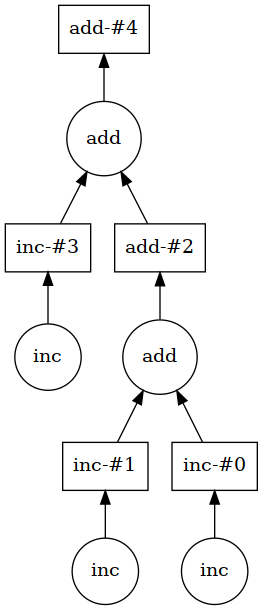

In [14]:
n.visualize()

The way to read this *directed, acyclic graph* is to start from the bottom. We need to calculate two results using the `inc` function, and the results of these feed into the `add` function. The result of this `add` is used along with the result from another `inc` call as inputs to another `add`, giving the final result.

The graph encodes all the tasks that need to be performed (circular nodes), outputs and inputs (square nodes) of those tasks, and dependencies between tasks (directed edges). The end result is we see that not all tasks need to be executed in serial: we could, for example, perform the first two increments at the same time if we had resources to do so.

Let's compute this graph:

In [15]:
%%time
n.compute()

CPU times: user 10.4 ms, sys: 2.58 ms, total: 13 ms
Wall time: 3.01 s


43

This was two seconds faster than the original block! From the graph, we can see that of the five operations we needed to execute, we could execute two pairings at the same time (the first two `inc` calls, then the `inc` and `add` call). This shaves off two seconds from the original five.

How does this actually work? When we call `compute`, the computation graph is fed to `dask`'s [threaded scheduler](http://dask.pydata.org/en/latest/scheduling.html#local-threads). Multiple threads are spawned, which can each compute pieces of the graph (somewhat) independently. This default scheduler works well in this case because our computation spends most of its time `time.sleep`-ing, which isn't executing code through the interpreter.

## Choosing schedulers

The `dask` library can be understood as two distinct components. The first component is the `delayed` function, which allows us to *build* task graphs. The second component is *executing* those graphs, and for that we have [several schedulers](http://dask.pydata.org/en/latest/scheduling.html#local-threads) to choose from:

1. **threaded** - the default choice when calling compute; uses threads, which work well for code that spends a lot of time *not* executing Python code (like waiting for remote i/o, running computations in compiled C, etc.).
2. **multiprocessing** - uses a pool of child processes, which works well for code that spends a lot of time executing Python code, since each process has its own Python interpreter. Takes longer to start up than threads, however.
3. **single thread** - uses no parallelism at all; executes computation serially in current thread. This is useful for debugging.
4. **distributed** - uses a pool of worker processes along with a scheduler process; useful for asynchronous and larger workloads. Despite the name, can be used on a single machine or scaled out to many

We'll introduce usage of the `multiprocessing` scheduler, as well as the `distributed` scheduler in the examples that follow.

## Parallelizing expensive operations with the `multiprocessing` scheduler

`dask` really shines when we have many tasks that are expensive (meaning, they take a lot of *time*), but that in principle could be done with some parallelism. To illustrate, we'll start by creating many large `numpy` arrays and writing these to files:

In [16]:
import numpy as np
import gc

In [17]:
for i in range(10):
    x = np.random.randn(10000, 10000)
    np.save("rand_array_{}.npy".format(i), x)
    
    # we'll call the garbage collector each loop so that
    # each array we previously created is destroyed
    # avoids eating up all the memory on our machine
    gc.collect()

Creating these files will take a bit of time, since it requires a lot of writing to disk. Once it's done, we should see them all in our current directory:

In [18]:
%ls rand*

rand_array_0.npy  rand_array_3.npy  rand_array_6.npy  rand_array_9.npy
rand_array_1.npy  rand_array_4.npy  rand_array_7.npy
rand_array_2.npy  rand_array_5.npy  rand_array_8.npy


Now, let's write a code block, without using `dask`, that loads each array from its file in sequence, gets the sum of all values in the array, and appends this result to a list. At the end, we'll take the sum of the list.

We can grab all file names matching a [glob](https://en.wikipedia.org/wiki/Glob_%28programming%29) pattern using the `glob.glob` function:

In [19]:
from glob import glob

Then, we'll write our block that gets the sum we want. Importantly, we don't try to load all these arrays at once, since our machine might not have enough memory to hold all of them at once:

In [20]:
%%time

sums = []
for file in glob('rand*.npy'):
    x = np.load(file)
    sums.append(x.sum())
    
res = sum(sums)

CPU times: user 668 ms, sys: 5.66 s, total: 6.33 s
Wall time: 10.5 s


In [21]:
res

-7060.843886278837

#### Challenge: Take the above code block and make it lazy. That is, make loading the numpy array `delay`-ed, `delay` the summing, and `delay` the final sum of all the individual sums

We'll take our code block from above, and wrap some of the function calls in `delayed`:

In [22]:
# initialize the list we want to hold results in
sums = []

# get files we want to load upfront
# we can't delay this since we need to iterate
# over definite values to build the graph
for file in glob('rand*.npy'):
    
    # delay creating an array from the file data
    x = delayed(np.load)(file)
    
    # call `sum` on the `Delayed` object, and append
    # result to our list; calling a method on a `Delayed` object
    # always yields another `Delayed` object
    sums.append(x.sum())
    
# delay the `sum` function call in the list of `Delayed` objects
res = delayed(sum)(sums)

We can use the `visualize` method to check our understanding of the graph we have built:

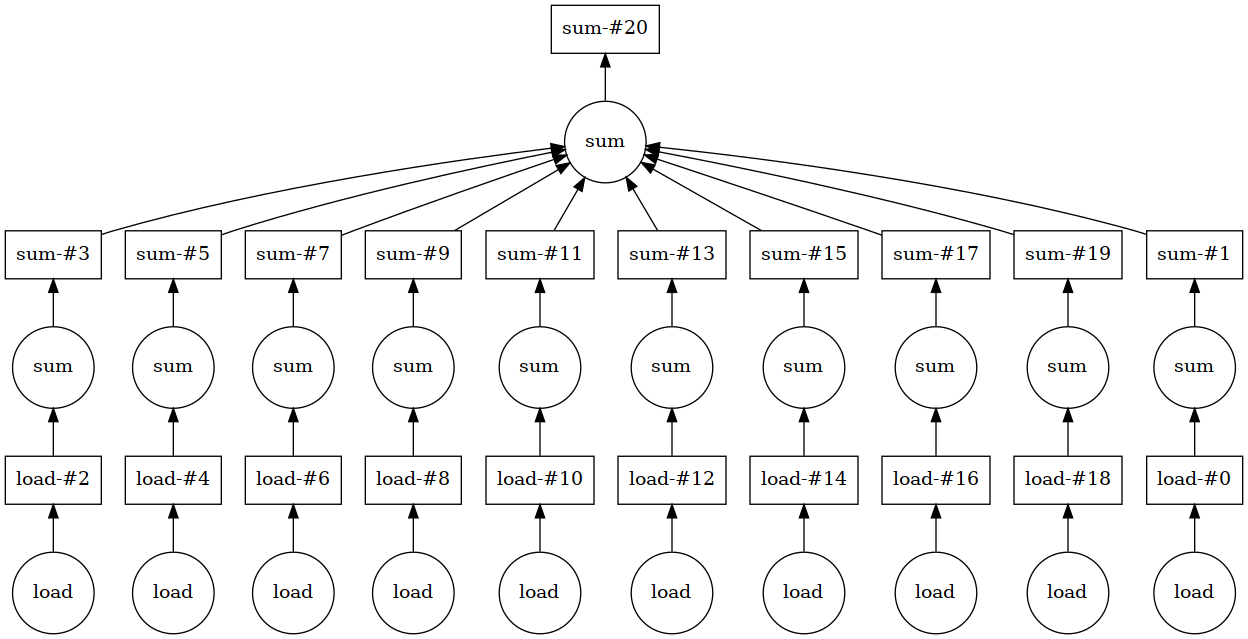

In [23]:
res.visualize()

This is a classic map-reduce operation, since we are taking many items, applying a function to each, then applying a function to those results to yield a final output. It is extremely parallelizable, since we apply a function independently to each item.

In [24]:
%%time

res.compute()

CPU times: user 1.08 s, sys: 8.52 s, total: 9.6 s
Wall time: 8.51 s


-7060.843886278837

Because we spend a lot of time in compiled C-code (`numpy.sum`) and disk IO (`np.load`), we see immediate benefits from the default **threaded** scheduler. We could try out the **multiprocessing** scheduler by specifying it as a keyword argument to `compute`:

In [25]:
%%time

res.compute(scheduler='processes')

CPU times: user 48.6 ms, sys: 19.5 ms, total: 68.2 ms
Wall time: 6.41 s


-7060.843886278837

A little bit faster. There's more overhead associated with starting up separate operating system processes, but despite the fact that much of our time is spent *not* interpreting Python code, we actually see comparable performance against the threaded scheduler, if not perhaps slightly better. 

It's important to note at this point that many operating systems, including Linux, cache files that have been recently read from disk into memory, so our timings are likely impacted by this. But what if we changed our code block so that it spent more time executing Python?

In [31]:
sums = []

for file in glob('rand*.npy'):
    
    x = delayed(np.load)(file)
    
    def slow_sum(x):
        result = 0
        for i in x.flatten():
            result += i
            
        return result
    
    # call the `slow_sum` function on the `Delayed` object,
    # and append result to our list
    sums.append(delayed(slow_sum)(x))
    
res = delayed(sum)(sums)

In [32]:
%%time

res.compute()

CPU times: user 1min 37s, sys: 11.9 s, total: 1min 49s
Wall time: 1min 45s


-7060.843886280541

Compare to the multiprocessing result:

In [33]:
%%time

res.compute(scheduler='processes')

CPU times: user 75.9 ms, sys: 34.7 ms, total: 111 ms
Wall time: 1min 2s


-7060.843886280541

The result takes almost half the time for the **multiprocessing** scheduler. This is because our `slow_sum` function iterates through each value in the `numpy` arrays, adding them up *in Python*. The Python interpreter is doing the work, not the underlying `numpy` executable, making it slow. Threading also doesn't help much here, due to the fact that the Python interpreter will only execute interpreted code in a single thread at a time, known as the [global interpreter lock](https://en.wikipedia.org/wiki/Global_interpreter_lock), or GIL.

Executing in a single thread, we get:

In [35]:
%%time

res.compute(scheduler='synchronous')

CPU times: user 1min 34s, sys: 8.01 s, total: 1min 42s
Wall time: 1min 46s


-7060.843886280541

This is comparable to the multi-threaded result, which makes sense considering the GIL only allows Python code to execute in one thread at a time. We gain nothing in this case using multiple threads.

Which scheduler makes sense for your task depends on what those tasks are doing. You can always try both and time their results when in doubt.

## Using the `distributed` scheduler

The **threaded** and **multiprocessing** schedulers work fine when using `dask` on a single machine, but they can't be used to distribute work across many machines, known as *scaling-out*. Even if your problem doesn't require many machines, we can still make use of the [`distributed`](https://distributed.readthedocs.io/en/latest/) scheduler. In addition to allowing us to scale-out if needed, it provides a ton of functionality worth becoming acquainted with.

The `distributed` scheduler is quite a bit different than the others we've introduced. It is more apt to describe it as a *cluster*, with many *worker* processes coordinated by a single *scheduler* process. The *scheduler* and *worker* processes may run on the same machine or different machines.

To use a `distributed` cluster to compute your `dask` graphs, we need to create a `Client` instance that will connect to the scheduler process:

In [41]:
from dask.distributed import Client

If the scheduler for the `distributed` cluster is already running on another machine, we would connect our `Client` object to it by specifying its IP and port:

    cl = Client("some_host_ip:8786")
    
Since we're going to run a cluster locally, we can start one up with a single scheduler and as many workers as we have processors on our machine by calling `Client` without any arguments:

In [39]:
cl = Client()

In [42]:
cl

Client Scheduler: tcp://127.0.0.1:33983,Cluster Workers: 4 Cores: 4 Memory: 16.21 GB


We can now use this to compute a graph. Let's use our task grap from earlier:

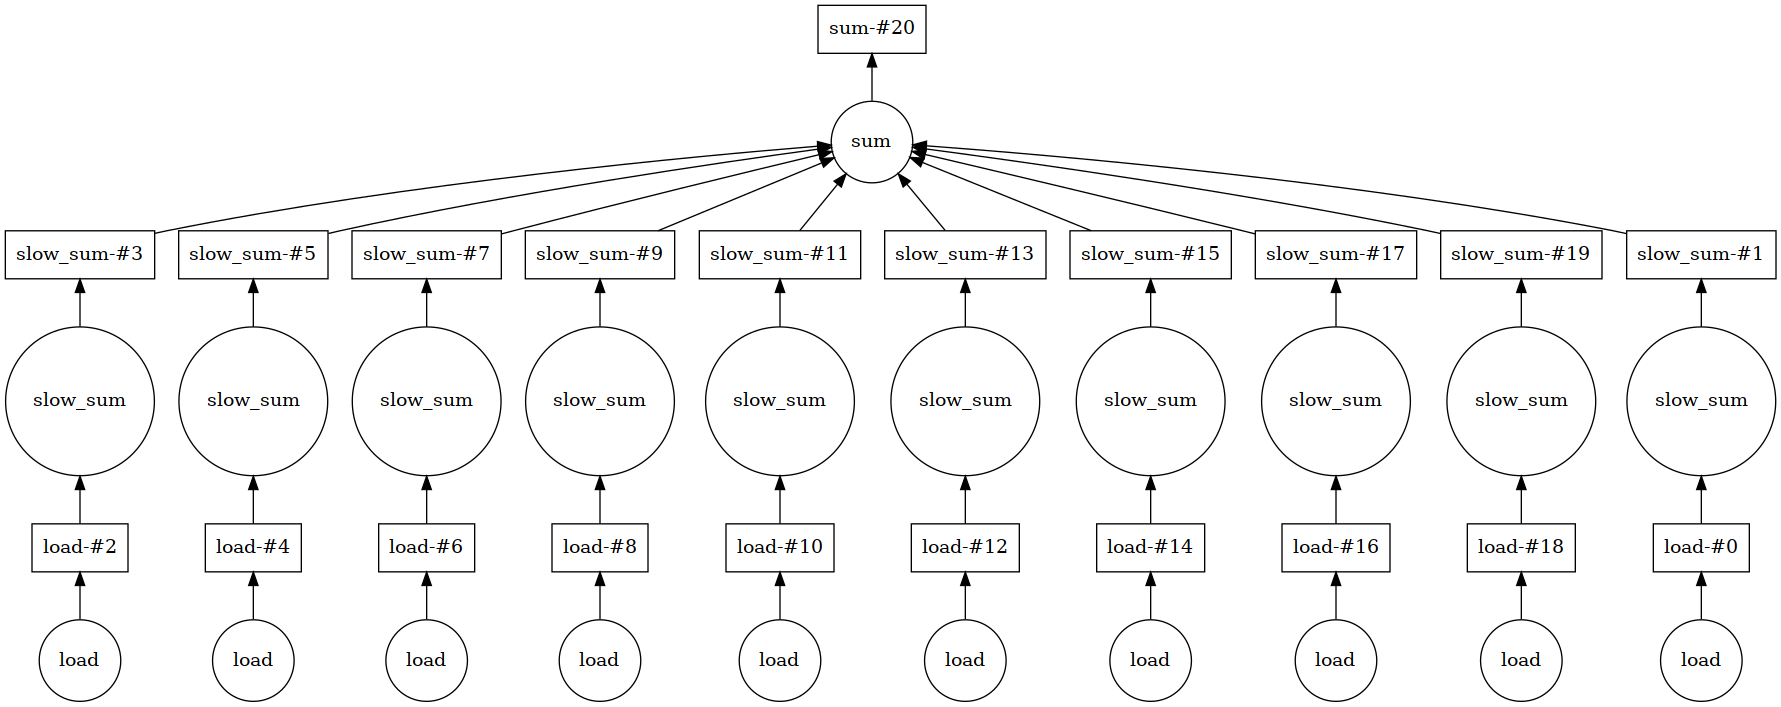

In [43]:
res.visualize()

We can compute the result by feeding this graph to `Client.compute`:

In [47]:
L = cl.compute(res)

This returns a `Future` object, which corresponds to a result that *may not* yet be available:

In [48]:
L

<Future: status: pending, key: sum-a99cb7bb-f893-4fb0-bd25-2bb95876202a>

The cluster is chewing through the graph we produced on other processes running on our machine, so we can continue to do other work in our current Python session while we wait. When we want our result, we can call `Client.gather`, feeding it the `Future` we want the corresponding result for. When the result is available, it is returned:

In [49]:
L

<Future: status: finished, type: float64, key: sum-a99cb7bb-f893-4fb0-bd25-2bb95876202a>

In [50]:
cl.gather(L)

-7060.843886280541

If you wish to run a scheduler with many workers, perhaps on many machines, see the [`dask` docs](https://distributed.readthedocs.io/en/latest/quickstart.html#setup-dask-distributed-the-hard-way) on how to do this.

## When to reach for a tool like `dask`

At the beginning of this lesson, we noted that there may be problems we face where operations either take a long time or take a lot of memory to complete, perhaps requiring that we try to *scale-out* our problem by using parallelism, either on a single machine or many. Chances are, however, that problems you face daily *will not* require these kinds of acrobatics. Though `dask` makes parallelism relatively easy, it can also complicate your workflow, especially if it isn't necessary.

That said, `dask` is an example of a powerful tool that can enable you to tackle problems that would have previously been a lot harder. At the simplest level, it can provide "parallelism-for-free", adding a speedup for tasks that don't necessarily need to be done in sequence. For more complex problems, it can allow us to spread execution of tasks on a large dataset across many machines, making our efforts more feasible.

For problems you encounter, start without a tool like `dask`. When it becomes clear `dask` can help, don't hesitate to reach for it and put it to work.